<a href="https://colab.research.google.com/github/darkosisak/DataWQU/blob/master/Capstone_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix: the Python code
The following represents the actionable Python code used in this project.

In [0]:
!pip install pyfolio
!pip install yfinance
!pip install mlfinlab
!pip install decisiveml

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pyfolio as pf
import mlfinlab as ml

# trendscanning
import sys
sys.path.append("..")
import decisiveml as dml

#from pandas_datareader import data as pdr

#from statsmodels.graphics.tsaplots import plot_acf

from numpy import array
#from numpy import argmax

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
#from mlfinlab.util import utils

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess

% matplotlib inline

In [0]:
# loading data
#r = pd.read_csv('/content/drive/My Drive/Colab Notebooks/financial-data-structures-master/GBPUSD_Hourly_Bid_2019.01.01_2019.12.31.csv')
#r = pd.read_csv('/content/drive/My Drive/Colab Notebooks/financial-data-structures-master/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')
r = pd.read_csv('https://capital20.com/WQU_CapstoneData/GBPUSD_TickBar_500_Bid_2019.01.02_2020.05.13.csv')


r.index = pd.to_datetime(r['Time (UTC)'])
r = r.drop(['Time (UTC)', 'EndTime'], axis=1)
prices = r["Close"] 

###############################################################################
# Features 1: Technical indicators
###############################################################################

def moving_average(x, n, type='simple'):
    """
    computing an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'exponential':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

def relative_strength(prices, n=14):
    """
    computing the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # because the diff is 1 shorter!

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi


def moving_average_convergence(x, nslow, nfast):
    """
    computing the MACD (Moving Average Convergence/Divergence) using a fast and
    slow exponential moving avg
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


def bbands(close_prices, window, no_of_stdev):
    #rolling_mean = close_prices.rolling(window=window).mean()
    #rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band


def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = r.copy()
    high = r['High']
    low = r['Low']
    close = r['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    atrx = atr*2
    return atr, atrx
  
# computing RSI
r['rsi'] = relative_strength(r['Close'], 14)

# computing BB
r['BBmid'], r['BBup'], r['BBlo'] = bbands(r['Close'], 20, no_of_stdev=2)


# computing the MACD indicator
nslow = 48
nfast = 26
nema = 20
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
r['MACD'] = macd
r['MACD_sig'] = moving_average(r['MACD'], nema, type='exponential')


# computing the MAs
ma20 = moving_average(prices, 25, type='simple')
ma60 = moving_average(prices, 130, type='exponential')
ma200 = moving_average(prices, 200, type='simple')

r['ATR'], r['ATRx'] = (atr(r['Close'], 7))

###############################################################################
# Signalling
###############################################################################

#### MA SIDE
r['dir'] = 0 
short_dir = (ma20 <= ma60) 
long_dir = (ma20 > ma60) 
r.loc[long_dir, 'dir'] = 1
r.loc[short_dir, 'dir'] = -1

#### ATR DIRECTION
r['atr_dir'] = 0 
short_atr_dir = ((r['Close'] <= (r['Close'].shift(-1) + r['ATRx'])) & (r['Close'].shift(-1) > (r['Close'].shift(-2) + r['ATRx'])))
long_atr_dir = ((r['Close'] > (r['Close'].shift(-1) - r['ATRx'])) & (r['Close'].shift(-1) <= (r['Close'].shift(-2) - r['ATRx'])))
r.loc[long_atr_dir, 'atr_dir'] = 1
r.loc[short_atr_dir, 'atr_dir'] = -1

#### MICRO-BREAKOUT
r['mbo'] = 0 
long_mbo = (r['High'] > r['High'].shift(-1))
short_mbo = (r['Low'] < r['Low'].shift(-1)) 
r.loc[long_mbo, 'mbo'] = 1
r.loc[short_mbo, 'mbo'] = -1
"""
#### RETRACEMENT
r['rtm'] = np.nan 
long_rtm = ((r['Low'].shift(-1) < r['BBmid'].shift(-1)) &  (ma20 > ma60))  
short_rtm = ((r['High'].shift(-1) > r['BBmid'].shift(-1)) & (ma20 <= ma60)) 
r.loc[long_rtm, 'rtm'] = 1
r.loc[short_rtm, 'rtm'] = -1

#### BOUNCE
r['bou'] = np.nan 
long_bou = ((r['Close'] > r['Open']) & (ma20 > ma60))  
short_bou = ((r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_bou, 'bou'] = 1
r.loc[short_bou, 'bou'] = -1
"""
#### RETRACEMENT BOUNCE
r['rbo'] = np.nan 
long_rbo = ((r['Low'].shift(-1) < r['BBmid'].shift(-1)) & (r['Close'] > r['Open']) & (ma20 > ma60))  
short_rbo = ((r['High'].shift(-1) > r['BBmid'].shift(-1)) & (r['Close'] < r['Open']) & (ma20 <= ma60)) 
r.loc[long_rbo, 'rbo'] = 1
r.loc[short_rbo, 'rbo'] = -1

#### OVERSOLD/OVERBOUGHT
r['over'] = 0 
oversold = (r['rsi'] <= 30) 
overbought = (r['rsi'] >= 70) 
r.loc[overbought, 'over'] = 1
r.loc[oversold, 'over'] = -1

#### BB STRETCH
r['BB_vol'] = 0 
not_oversold = (r['Close'] >= r['BBlo']) 
not_overbought = (r['Close'] <= r['BBup']) 
r.loc[not_oversold, 'BB_vol'] = -1
r.loc[not_overbought, 'BB_vol'] = 1

#### MACD MOMENTUM
r['MACD_mom'] = 0 
down = (r['MACD'] <= r['MACD_sig']) 
up = (r['MACD'] > r['MACD_sig']) 
r.loc[up, 'MACD_mom'] = 1
r.loc[down, 'MACD_mom'] = -1

##### SIDES
r['BB_sides'] = 0 
long_signals = (r['Close'] <= r['BBlo']) 
short_signals = (r['Close'] >= r['BBup']) 
r.loc[long_signals, 'BB_sides'] = 1
r.loc[short_signals, 'BB_sides'] = -1

# Remove Look ahead bias by lagging the signal
r['dir'] = r['dir'].shift(1)
r['atr_dir'] = r['atr_dir'].shift(1)
r['rbo'] = r['rbo'].shift(1)
r['over'] = r['over'].shift(1)
r['MACD_mom'] = r['MACD_mom'].shift(1)
r['BB_sides'] = r['BB_sides'].shift(1)

print("ATR Direction:")
print(r.atr_dir.value_counts())
print("\n MA Direction:")
print(r.dir.value_counts())
print("\n Retracement Bounces:")
print(r.rbo.value_counts())
print("\n Micro-Breakouts:")
print(r.mbo.value_counts())
print("\n Oversold/overbought:")
print(r.over.value_counts())
print("\n BB Volatility:")
print(r.BB_vol.value_counts())
print("\n MACD momentum:")
print(r.MACD_mom.value_counts())
print("\n BB Sides:")
print(r.BB_sides.value_counts())


In [54]:
trend = dml.getBinsFromTrend(
    molecule=r["rbo"].dropna().index, 
    close=r.Close, 
    span=[22, 44, 11],)
trend

,t1,tVal,bin
Time (UTC),,,
2019-01-02 00:29:46.621,2019-01-02 06:19:18.633,-5.88172,-1.0
2019-01-02 00:45:49.466,2019-01-02 06:28:38.307,4.33357,1.0
2019-01-02 01:45:00.558,2019-01-02 06:47:28.828,7.32728,1.0
2019-01-02 02:20:55.061,2019-01-02 07:06:06.267,9.84793,1.0
2019-01-02 02:55:14.705,2019-01-02 07:28:42.635,12.2189,1.0
...,...,...,...
2020-05-13 08:35:22.414,2020-05-13 11:27:21.776,6.76847,1.0
2020-05-13 08:45:14.098,2020-05-13 11:36:00.916,7.13061,1.0
2020-05-13 09:01:52.653,2020-05-13 11:48:20.402,7.48303,1.0


In [0]:
r["trend"] = trend.bin
end = trend.t1
r.loc[end, "trend"] = 0
r.trend.fillna(method="ffill", inplace=True)
r.trend.fillna(0, inplace=True)

# get the unfiltered trends
#r["trendstart"] = r[(r.trend != 0) & (r.trend.shift(1) == 0)].Close
#r["trendend"] = r[(r.trend == 0) & (r.trend.shift(1) != 0)].Close

In [0]:
###############################################################################
# Features 2: More features
###############################################################################
# Log Returns
r['log_ret'] = np.log(r['Close']).diff()

# Momentum
r['mom1'] = r['Close'].pct_change(periods=1)
"""
r['mom2'] = r['Close'].pct_change(periods=2)
r['mom3'] = r['Close'].pct_change(periods=3)
r['mom4'] = r['Close'].pct_change(periods=4)
r['mom5'] = r['Close'].pct_change(periods=5)
"""

# Log -t returns
#r['log_t1'] = r['log_ret'].shift(1)
#r['log_t2'] = r['log_ret'].shift(2)
#r['log_t3'] = r['log_ret'].shift(3)
#r['log_t4'] = r['log_ret'].shift(4)
#r['log_t5'] = r['log_ret'].shift(5)


# Volatility
window_stdev = 50
r['vol_50'] = r['log_ret'].rolling(window=window_stdev, min_periods=50, center=False).std()
#r['vol_13'] = r['log_ret'].rolling(window=window_stdev, min_periods=13, center=False).std()
#r['vol_7'] = r['log_ret'].rolling(window=window_stdev, min_periods=7, center=False).std()

# Serial Correlation
window_autocorr = 50
r['autocorr_1'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
#r['autocorr_2'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
#r['autocorr_3'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
#r['autocorr_4'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
#r['autocorr_5'] = r['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Backup full features dataframe
r_bck = r.copy()

In [0]:
r

In [57]:
# Creating a separate set for TB labelling
#data = r['2019-01-02':'2019-12-31'].copy()
data = r.copy()
data.dropna(axis=0, how='any', inplace=True)
data

,Open,High,Low,Close,Volume,rsi,BBmid,BBup,BBlo,MACD,MACD_sig,ATR,ATRx,dir,atr_dir,mbo,rbo,over,BB_vol,MACD_mom,BB_sides,trend,log_ret,mom1,vol_50,autocorr_1
Time (UTC),,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02 07:45:08.608,1.27541,1.27546,1.27472,1.27491,672.62,44.901732,1.275434,1.277153,1.273715,0.000902,0.000012,0.000606,0.001211,1.0,0.0,-1,1.0,0.0,1,1.0,0.0,0.0,-0.000392,-0.000392,0.000284,-0.083763
2019-01-02 07:54:57.328,1.27532,1.27545,1.27475,1.27490,882.34,45.362377,1.275373,1.276960,1.273786,0.000998,0.000200,0.000634,0.001269,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,-0.000329,-0.000329,0.000290,-0.136186
2019-01-02 08:01:14.314,1.27572,1.27605,1.27528,1.27528,758.77,49.552014,1.275394,1.276845,1.273943,0.001049,0.000377,0.000705,0.001409,1.0,0.0,1,1.0,0.0,1,1.0,0.0,0.0,-0.000345,-0.000345,0.000308,-0.215949
2019-01-02 08:05:16.440,1.27546,1.27594,1.27530,1.27530,696.47,49.657359,1.275391,1.276705,1.274076,0.001045,0.000535,0.000702,0.001404,1.0,0.0,1,1.0,0.0,1,1.0,0.0,-1.0,-0.000125,-0.000125,0.000308,-0.220808
2019-01-02 08:23:21.809,1.27284,1.27287,1.27226,1.27265,832.50,29.844566,1.274329,1.276801,1.271858,0.000131,0.000764,0.000729,0.001459,1.0,0.0,-1,1.0,0.0,1,-1.0,0.0,-1.0,-0.000181,-0.000181,0.000312,-0.106176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-13 09:33:11.767,1.22831,1.22901,1.22829,1.22854,949.03,58.397513,1.227758,1.228926,1.226590,-0.000437,0.000063,0.000758,0.001516,-1.0,0.0,-1,-1.0,0.0,1,-1.0,0.0,0.0,0.000228,0.000228,0.000435,-0.386374
2020-05-13 10:45:08.405,1.22928,1.22935,1.22898,1.22909,783.52,50.850221,1.229194,1.231215,1.227173,0.000549,-0.000066,0.000759,0.001518,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,-0.000171,-0.000171,0.000408,-0.110390
2020-05-13 10:59:17.518,1.22934,1.22970,1.22919,1.22954,781.40,54.929044,1.229240,1.231080,1.227399,0.000617,0.000026,0.000753,0.001506,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,0.000163,0.000163,0.000403,-0.128658


In [58]:
###############################################################################
# Triple Barrier Labeling
###############################################################################
# computing daily volatility
daily_vol = ml.util.get_daily_vol(close=data['Close'], lookback=50)
daily_vol2 = data['ATR']

# applying Symmetric CUSUM Filter and getting timestamps for events given the daily volatility
#cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol['2019-01-02':].mean()*0.04)
cusum_events = filters.cusum_filter(data['Close'], threshold = daily_vol2)

# compute vertical barrier
#vertical_barriers = labeling.add_vertical_barrier(t_events = cusum_events, close=data['Close'], num_hours=6)

pt_sl = [1, 2]
min_ret = 0.0005 
triple_barrier_events = labeling.get_events(close=data['Close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol2,
                                            min_ret=min_ret,
                                            num_threads=3,
                                            vertical_barrier_times=False,
                                            side_prediction=data['mbo'])                # Here we choose one of the signals for the primary model 
# labeling
labels = ml.labeling.get_bins(triple_barrier_events, data['Close'])
labels.side.value_counts()

2020-05-17 16:41:14.091868 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


-1.0    2406
 1.0    1787
Name: side, dtype: int64

In [59]:
###############################################################################
# Primary Model Forecast
###############################################################################
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1915
           1       0.54      1.00      0.70      2278

    accuracy                           0.54      4193
   macro avg       0.27      0.50      0.35      4193
weighted avg       0.30      0.54      0.38      4193

Confusion Matrix
[[   0 1915]
 [   0 2278]]

Accuracy
0.5432864297638922


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
r = r_bck.copy()

In [60]:
###############################################################################
# Preparing Features Data
###############################################################################
X = r.loc[labels.index, :]
# dropping unwanted columns
X.drop(['BBmid', 'BBup','BBlo','Open',  'over', #'sides',
        'dir', #'atr_dir', #'trend', 
        #'mbo',
        #'MACD_mom', 
        'High', 'Low', 'Close', 'ATRx', 'log_ret', 'rbo', 
        'MACD', 'rsi', 'vol_50', 'mom1', #'autocorr_1',
        #'mom2','mom3', 'mom4','mom5', 
        #'vol_13', 'vol_7', 'log_t2', 'log_t3', 'log_t4', 'log_t5',
        'MACD_sig'], axis=1, inplace=True)
y = labels['bin']
y.value_counts()

1    2278
0    1915
Name: bin, dtype: int64

In [0]:
###############################################################################
# In-Sample training and testing
###############################################################################
# splitting data into training and validation (test) sets
X_training_validation = X['2019-01-02':'2019-12-31']
y_training_validation = y['2019-01-02':'2019-12-31']
X_train, X_test, y_train, y_test = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
"""
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)
"""
train_df['bin'].value_counts()

# Creating training data
X_train = train_df.loc[:, train_df.columns != 'bin']
y_train = train_df['bin']

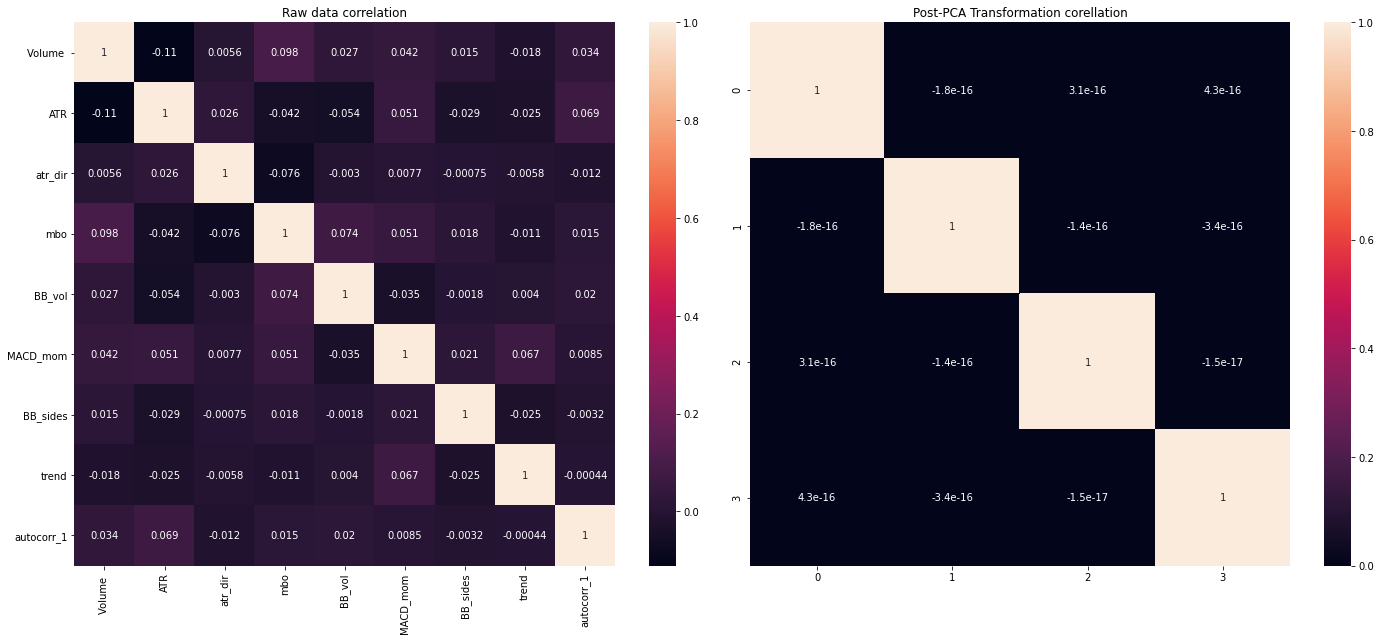

In [62]:
###############################################################################
# Principal Component Analysis
###############################################################################
def preprocessing_transformation(X_train,X_test):
    #imputer = preprocessing.Imputer() # deprecated, using SimpleImputer instead
    imputer = SimpleImputer() 
    scaler = preprocessing.MinMaxScaler()
    X_train_trans = imputer.fit_transform(X_train)
    X_train_trans = scaler.fit_transform(X_train)
    X_test_trans = imputer.fit_transform(X_test)
    X_test_trans = scaler.fit_transform(X_test)
    return X_train_trans, X_test_trans

# preprocessing
X_train_pre_trans, X_test_pre_trans = preprocessing_transformation(X_train,X_test)
X_train_pre_trans, X_test_pre_trans = np.nan_to_num(X_train_pre_trans),np.nan_to_num(X_train_pre_trans)

def pca_transformation(X_train,X_test,explained_ratio_thresh=0.02):
    pca = PCA()
    pca.fit(X_train)
    n_components = (pca.explained_variance_ratio_>explained_ratio_thresh).sum()
    X_train_trans = pca.transform(X_train)[:,:n_components]
    X_test_trans = pca.transform(X_test)[:,:n_components]
    return X_train_trans, X_test_trans

# transforming
X_train_pca_trans, X_test_pca_trans = pca_transformation(X_train_pre_trans, X_test_pre_trans)

# plotting
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.title("Raw data correlation")
sns.heatmap(pd.DataFrame(X_train, columns = X_train.columns).corr(),annot=True)

plt.subplot(1,2,2)
plt.title("Post-PCA Transformation corellation")
sns.heatmap(pd.DataFrame(X_train_pca_trans).corr(),annot=True)
plt.tight_layout()

In [63]:
###############################################################################
# Meta Model Fitting
###############################################################################
# Finding best parameters for the random forest model
parameters = {'max_depth':[4,6,8],
              'n_estimators':[512, 1024, 2048, 4096],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3) 
    clf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))
    print(clf.cv_results_['mean_test_score'])
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth'], clf.best_params_['random_state']

# extracting parameters
n_estimator, depth, c_random_state = perform_grid_search(np.nan_to_num(X_train), np.nan_to_num(y_train))
print(n_estimator, depth, c_random_state)


[0.69429323 0.69719494 0.69678311 0.69728317 0.71205652 0.71144871
 0.71034029 0.71102947 0.70900999 0.71048113 0.71039319 0.7093185 ]
512 6 42


In [0]:
depth = 7
n_estimator = 1024
c_random_state = 42

In [64]:
# Random forest model training, to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)
"""
MLdP pdf p125, book p98

rf=RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap=False, class_weight='balanced_subsample',
                          random_state=c_random_state) 
rf=BaggingClassifier(base_estimator=rf,n_estimators=1000, max_samples=100, max_features=1.)

"""
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, class_weight='balanced_subsample', 
                            criterion='entropy', min_weight_fraction_leaf=0.05, max_features='auto', random_state=c_random_state)
rf.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.05,
                       n_estimators=512, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

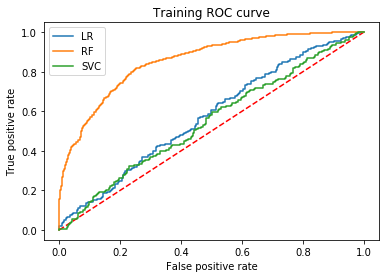

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(tpr, fpr, label='SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

Confusion Matrix
[[722 270]
 [277 925]]

Accuracy
0.7506836827711941


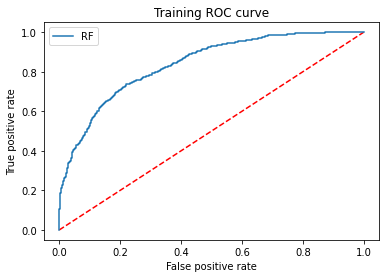

In [0]:
###############################################################################
# Training Metrics
###############################################################################

y_pred_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_train))

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

rf_t_auc = roc_auc_score(y_train, y_pred_rf)

#print(classification_report(y_train, y_pred_rf))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

Train ROC AUC=0.775
Test ROC AUC=0.726


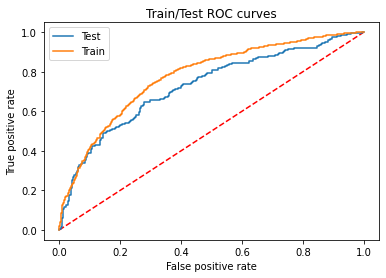

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       241
           1       0.72      0.66      0.69       307

    accuracy                           0.66       548
   macro avg       0.66      0.66      0.66       548
weighted avg       0.67      0.66      0.66       548

Confusion Matrix
[[161  80]
 [105 202]]

Accuracy
0.6624087591240876


In [65]:
y_pred_rf = rf.predict_proba(np.nan_to_num(X_train))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_train))

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

rf_t_auc = roc_auc_score(y_train, y_pred_rf)

###############################################################################
# Validation Metrics
############################################################################### 

y_pred_rf = rf.predict_proba(np.nan_to_num(X_test))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_test))

vfpr_rf, vtpr_rf, _ = roc_curve(y_test, y_pred_rf)


rf_v_auc = roc_auc_score(y_test, y_pred_rf)

print('Train ROC AUC=%.3f' % (rf_t_auc))
print('Test ROC AUC=%.3f' % (rf_v_auc))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(vfpr_rf, vtpr_rf, label='Test')
plt.plot(fpr_rf, tpr_rf, label='Train')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Train/Test ROC curves')
plt.legend(loc='best')
plt.show()
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))


In [66]:
# Primary model on validation time-span
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(X_test.index.min())
end = primary_forecast.index.get_loc(X_test.index.max()) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       241
           1       0.56      1.00      0.72       307

    accuracy                           0.56       548
   macro avg       0.28      0.50      0.36       548
weighted avg       0.31      0.56      0.40       548

Confusion Matrix
[[  0 241]
 [  0 307]]

Accuracy
0.5602189781021898


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


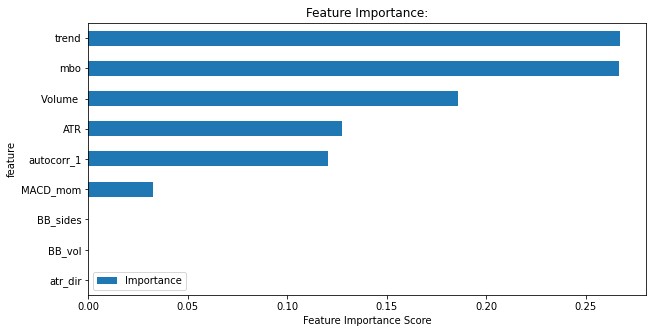

In [67]:
###############################################################################
# Feature Importance
###############################################################################
title = 'Feature Importance:'
figsize = (10, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')

plt.show()

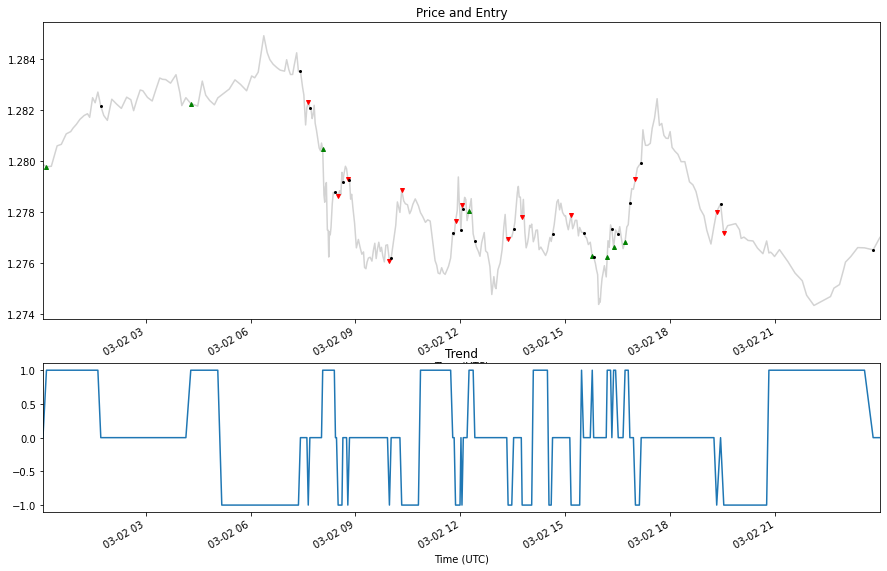

In [0]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(nrows=2, ncols=1, 
                         figsize=(15,10), 
                         gridspec_kw={'height_ratios': [2,1]})

rs = r['2020-03-02':'2020-03-02'].copy()
# get the unfiltered trends
rs["trendlong"] = r[(r.trend == 1) & (r.trend.shift(1) == 0)].Close
rs["trendshort"] = r[(r.trend == -1) & (r.trend.shift(1) == 0)].Close
rs["trendend"] = r[(r.trend == 0) & (r.trend.shift(1) != 0)].Close
#rs.Close.plot(color="gray")

rs.Close.plot(ax=axes[0], color="lightgray")
#r.mavg.plot(ax=axes[0], color="gray", linestyle="--")
#r.entry.plot(ax=axes[0], marker=".", color="gray")
rs.trendlong.plot(ax=axes[0], marker="^", markersize=4, color="green")
rs.trendshort.plot(ax=axes[0], marker="v", markersize=4, color="red")
rs.trendend.plot(ax=axes[0], marker="o", markersize=2, color="black")

rs.trend.plot(ax=axes[1])

axes[0].title.set_text('Price and Entry')
axes[1].title.set_text('Trend')

#r.drop(['trendstart', 'trendend'], axis=1, inplace=True)

In [68]:
###############################################################################
# In-Sample Trading Performance
###############################################################################
# Without meta-labeling
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

# For using Trend-Scanning Labeling instead of TBL
valid_dates = X_test.index
trend2 = trend.copy()
trend2["ret"] = trend.tVal*0.0001

# Downsample to daily
prim0_rets_test = labels.loc[valid_dates, 'ret']        # use trend2 in place of labels for trend-scanning labeling
daily_rets_prim0 = get_daily_returns(prim0_rets_test)

pf.show_perf_stats(daily_rets_prim0)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,19.8%
Cumulative returns,4.1%
Annual volatility,12.5%
Sharpe ratio,1.51
Calmar ratio,4.78
Stability,0.10
Max drawdown,-4.2%


In [69]:
# With meta-labeling
prim1_rets_test = labels.loc[valid_dates, 'ret'] * y_pred
daily_rets_prim1 = get_daily_returns(prim1_rets_test)

pf.show_perf_stats(daily_rets_prim1)

#pf.show_perf_stats(labels.loc[valid_dates, 'ret'] * y_pred)

Start date,2019-10-15
End date,2019-12-31
Total months,2
,Backtest
Annual return,138.6%
Cumulative returns,21.3%
Annual volatility,8.6%
Sharpe ratio,10.20
Calmar ratio,361.18
Stability,0.93
Max drawdown,-0.4%


              precision    recall  f1-score   support

           0       0.66      0.70      0.68       646
           1       0.70      0.66      0.68       701

    accuracy                           0.68      1347
   macro avg       0.68      0.68      0.68      1347
weighted avg       0.68      0.68      0.68      1347

Confusion Matrix
[[449 197]
 [235 466]]

Accuracy
0.6792873051224945


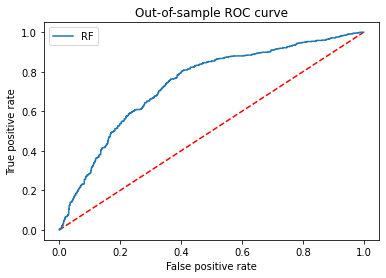

In [70]:
###############################################################################
# Out-of-Sample Testing
###############################################################################
# Extracting out-of-sample data (forward-test)
X_forward = X['2020-01-02':'2020-04-30']
y_forward = y['2020-01-02':'2020-04-30']

# Performance Metrics
y_pred_rf = rf.predict_proba(np.nan_to_num(X_forward))[:, 1]
y_pred = rf.predict(np.nan_to_num(X_forward))
fpr_rf, tpr_rf, _ = roc_curve(np.nan_to_num(y_forward), y_pred_rf)
print(classification_report(np.nan_to_num(y_forward), y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_forward, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_forward, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Out-of-sample ROC curve')
plt.legend(loc='best')
plt.show()

In [71]:
# Primary model out-of-sample
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2020-01-02':'2020-04-30']

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       646
           1       0.52      1.00      0.68       701

    accuracy                           0.52      1347
   macro avg       0.26      0.50      0.34      1347
weighted avg       0.27      0.52      0.36      1347

Confusion Matrix
[[  0 646]
 [  0 701]]

Accuracy
0.520415738678545


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,-65.0%
Cumulative returns,-29.8%
Annual volatility,19.7%
Sharpe ratio,-5.22
Calmar ratio,-2.08
Stability,0.81
Max drawdown,-31.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.30,2020-01-13,2020-04-30,NaT,NaN
1,0.00,2020-01-03,2020-01-03,2020-01-03,1
2,0.00,2020-01-03,2020-01-03,2020-01-03,1
3,0.00,2020-01-03,2020-01-03,2020-01-03,1
4,0.00,2020-01-03,2020-01-03,2020-01-03,1


Stress Events,mean,min,max
New Normal,-0.41%,-5.16%,1.99%


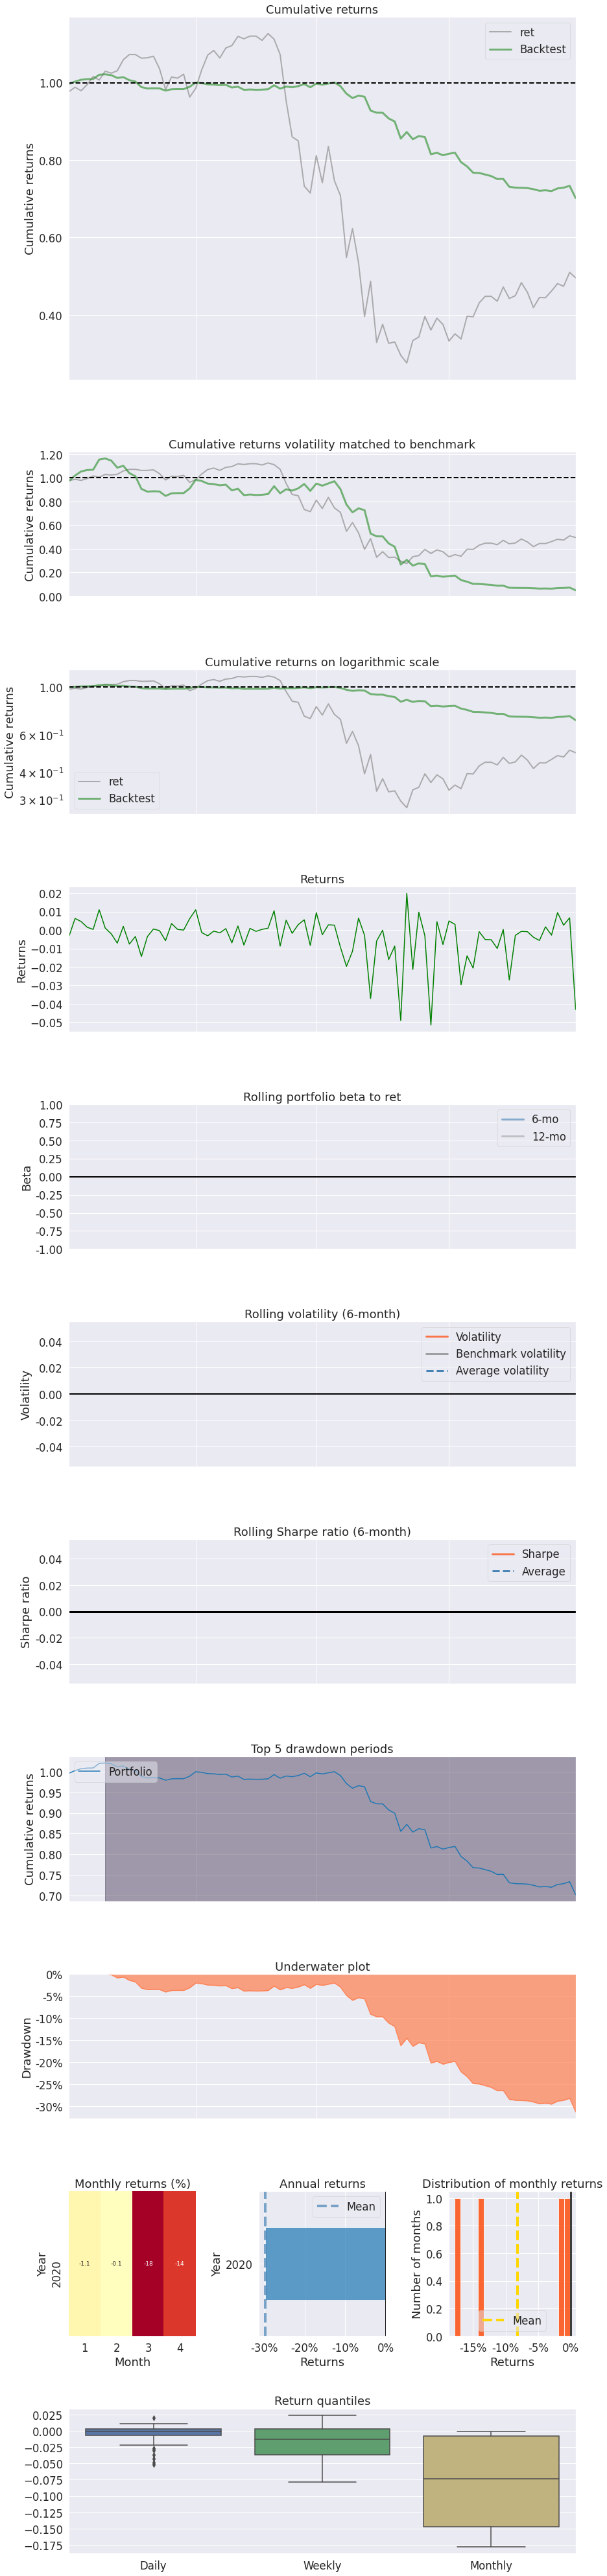

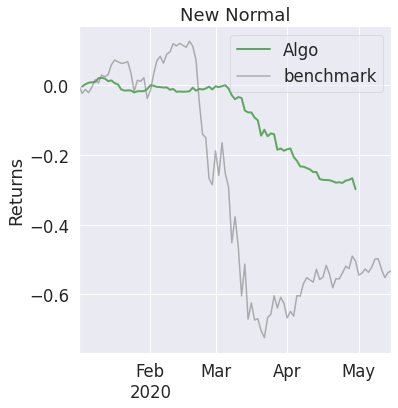

In [124]:
###############################################################################
# Out-of-Sample Trading Performance
###############################################################################
# Without meta-labeling

fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

#pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
pf.create_full_tear_sheet(daily_rets_prim, round_trips = False, benchmark_rets=bench_ret)

In [0]:
# "Simulation"
#labels_bckup = labels.copy()
commission = 0.00006
avg_slip = 0.00005
labels["net_rt"] = labels.ret-commission-avg_slip

In [0]:
import yfinance as yf

sp500 = yf.Ticker("^GSPC")

# get historical market data
bench = sp500.history(period="ytd")
bench['ret'] =(bench['Close'].diff())*0.001
bench_ret = bench['ret']

In [112]:
## TEMP
fwd_test_dates = X_forward.index

# Downsample to daily
prim_rets_test = labels.loc[fwd_test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

pf.show_perf_stats(daily_rets_prim)
# pf.show_perf_stats(labels.loc[fwd_test_dates, 'ret'])
# pf.create_returns_tear_sheet(daily_rets_prim, benchmark_rets=None)

# With meta-labeling
print("\n \n With meta-labeling:")

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.show_perf_stats(daily_rets_meta)



Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,-65.0%
Cumulative returns,-29.8%
Annual volatility,19.7%
Sharpe ratio,-5.22
Calmar ratio,-2.08
Stability,0.81
Max drawdown,-31.3%



 
 With meta-labeling:


Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,475.4%
Cumulative returns,80.4%
Annual volatility,18.6%
Sharpe ratio,9.55
Calmar ratio,315.05
Stability,0.88
Max drawdown,-1.5%


Start date,2020-01-03
End date,2020-04-30
Total months,4
,Backtest
Annual return,475.4%
Cumulative returns,80.4%
Annual volatility,18.6%
Sharpe ratio,9.55
Calmar ratio,315.05
Stability,0.88
Max drawdown,-1.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.51,2020-01-17,2020-01-23,2020-01-31,11
1,1.28,2020-03-26,2020-03-27,2020-03-30,3
2,0.52,2020-04-02,2020-04-07,2020-04-08,5
3,0.32,2020-02-20,2020-02-21,2020-02-24,3
4,0.30,2020-03-31,2020-04-01,2020-04-02,3


Stress Events,mean,min,max
New Normal,0.70%,-1.28%,5.17%


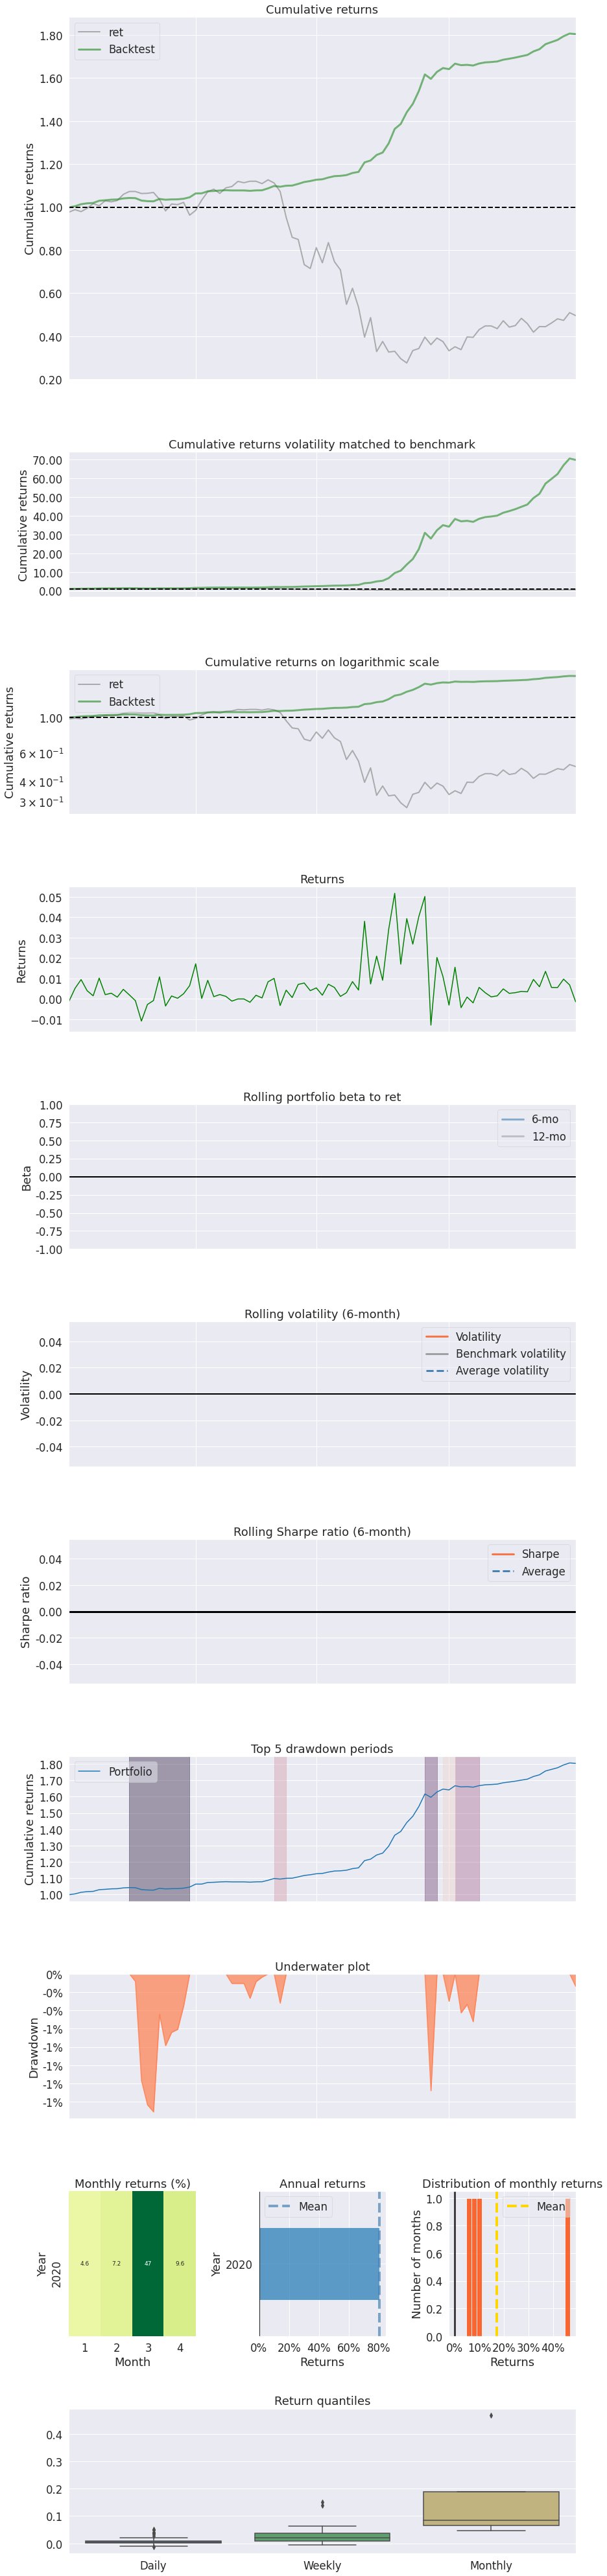

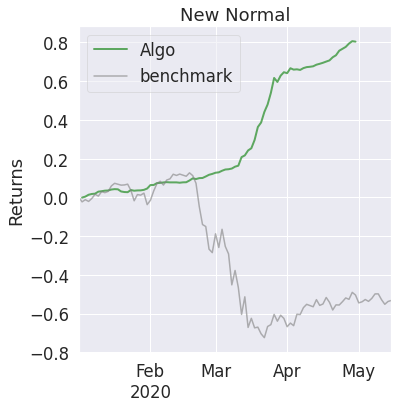

In [126]:
# With meta-labeling

warnings.filterwarnings("ignore")

meta_returns = labels.loc[fwd_test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

pf.create_full_tear_sheet(daily_rets_meta, round_trips = False, benchmark_rets=bench_ret)

In [0]:
######### TEMP
def atr_trailing (prices):

    if (r['Close'].shift(1) < ATRtr) & (r['Close'] > ATRtr):
      ATRtr = r['Close'] - r['ATRx']
    elif (r['Close'].shift(1) > ATRtr) & (r['Close'] < ATRtr):
      ATRtr = r['Close'] + r['ATRx']

    if r['Close'] > ATRtr:
      ATRtr2 = r['Close'] - r['ATRx']
      if ATRtr2 > ATRtr:
        ATRtr = ATRtr2
    elif r['Close'] < ATRtr:
      ATRtr2 = r['Close'] + r['ATRx']
      if ATRtr2 < ATRtr:
        ATRtr = ATRtr2

    return atr_trailing

r['ATRtr'] = (atr_trailing(r['Close']))

"""
    if ((r['Close'].shift(1) < (r['Close'] + r['ATRx'])) & (r['Close'] > (r['Close'] + r['ATRx']))):
      ATRtr = r['Close'] - r['ATRx']
    elif ((r['Close'].shift(1) > (r['Close'] - r['ATRx'])) & (r['Close'] < (r['Close'] - r['ATRx']))):
      ATRtr = r['Close'] + r['ATRx']
    
    if r['Close'] > ATRtr:
      ATRtr2 = r['Close'] - r['ATRx']
      if ATRtr2 > ATRtr:
        ATRtr = ATRtr2
    elif r['Close'] < ATRtr:
      ATRtr2 = r['Close'] + r['ATRx']
      if ATRtr2 < ATRtr:
        ATRtr = ATRtr2
        """
    #atrtr = ATRtr
    #return atr, atrx#, atrtr
"""
def atr_trailing (prices):
    data2 = r.copy()
    close = r['Close']
    if (r['Close'].shift(1) < r['Close'] + r['ATRx']) & (r['Close'] > r['Close'] + r['ATRx']):
      ATRtr = r['Close'] - r['ATRx']
    elif (r['Close'].shift(1) > r['Close'] - r['ATRx']) & (r['Close'] < r['Close'] - r['ATRx']):
      ATRtr = r['Close'] + r['ATRx']

    if r['Close'] > ATRtr:
      ATRtr2 = r['Close'] - r['ATRx']
      if ATRtr2 > ATRtr:
        ATRtr = ATRtr2
    elif r['Close'] < ATRtr:
      ATRtr2 = r['Close'] + r['ATRx']
      if ATRtr2 < ATRtr:
        ATRtr = ATRtr2
      atr_traling = ATRtr
    return atr_trailing
"""
